In [1]:
from __future__ import print_function
%matplotlib inline

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import spacy
import en_core_web_sm
import unicodedata

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
nlp = en_core_web_sm.load()

In [3]:
def load_data(reviews_path):
    
    df1 = pd.read_csv(reviews_path)
    
    df1 = df1.replace('__label__1', 0)
    df1= df1.replace('__label__2', 1)
    
    return df1

reviews_path = os.path.join(PROJ_ROOT, "data", "raw", "book_reviews.csv")
    
df1 = load_data(reviews_path)   

assert df1.shape == (2808, 2)

In [4]:
def load_data(reviews_path):
    
    df2 = pd.read_csv(reviews_path)
    df2['label'] = np.where(df2['review_rating'] < 4, 0, 1)
    df2['text'] = df2['review_text']
    df2 = df2 [['text', 'label']]
    return df2

reviews_path = os.path.join(PROJ_ROOT, "data", "raw", "review.csv")
    
df2 = load_data(reviews_path) 

assert df2.shape == (460, 2)

In [5]:
frames = [df1, df2]
df = pd.concat(frames)
df.shape

(3268, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3268 entries, 0 to 459
Data columns (total 2 columns):
text     3268 non-null object
label    3268 non-null int64
dtypes: int64(1), object(1)
memory usage: 76.6+ KB


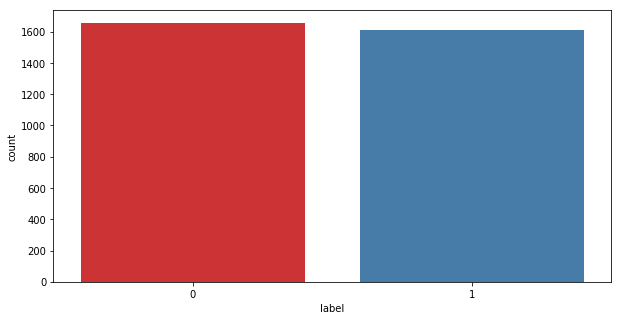

In [7]:
def plot_df(data_frame):
    plt.figure(figsize = (10, 5))
    chart = sns.countplot(data_frame['label'], 
                      palette="Set1"
                     )
    plt.show()

plot_df(df)

In [8]:
df.label.value_counts()

0    1656
1    1612
Name: label, dtype: int64

The final dataframe has roughly equal counts of labels (0 indicating negative sentiment, 1 indicating positive sentiment).

# Preprocessing

In [9]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [10]:
df['text'] = [remove_accented_chars(sent) for sent in df['text']]
    

In [11]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [12]:
df['text'] = [lemmatize_text(sent) for sent in df['text']]

In [13]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [14]:
df['text'] = [remove_special_characters(sent) for sent in df['text']]

In [15]:
df.head()

,text,label
0,fascinating view into the past this book be f...,1
1,a very amusing look at the past I be hope for...,1
2,do not like I do not like this version of th...,0
3,two diva that should shut up here be two so...,0
4,Movie Version be much well the movie version...,0


In [16]:
df.tail()

,text,label
455,a second chance story full of suspense traged...,1
456,a lovely wordless picture book with endearing ...,1
457,I be glad a gay writer win the Pulitzer for wr...,0
458,good world and interesting story but the chara...,0
459,sex pair of hand and love time 10laura be sho...,1


In [17]:
# Remove extra white-space from text
df['text'] = [re.sub(' +', ' ', sent) for sent in df['text']]

In [18]:
df.head()

,text,label
0,fascinating view into the past this book be fa...,1
1,a very amusing look at the past I be hope for ...,1
2,do not like I do not like this version of the ...,0
3,two diva that should shut up here be two songb...,0
4,Movie Version be much well the movie version o...,0


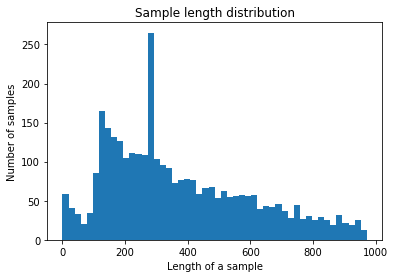

In [22]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

plot_sample_length_distribution(df['text'])

Most sentences contain anywhere from 25 words to about 50 words. The longest sentence contains close to 200 words and the shortest sentence containing no words.

In [19]:
df.to_pickle("./reviews5.pkl")

In [20]:
#Remove stopwords and separate input text data (x) from labels/ target variable (y)
from sklearn.feature_extraction.text import CountVectorizer

def make_features(df, vectorizer=None):  
    if vectorizer is None:
        vectorizer = CountVectorizer(stop_words = 'english', max_df=0.5, ngram_range=(1, 3))
    x = vectorizer.fit_transform(df['text'])
    y = df['label']
    return x, y

x, y = make_features(df)

In [23]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state=42)

clf = BernoulliNB()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
clf.score(x_test, y_test)

0.8027522935779816